<h1>Feature Engineering</h1>


In [866]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import LineCollection

%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


----
<p>I will generate 150 points for the training set. Points on or below the axis will be blue. Points above the axis will be red.</p>

----

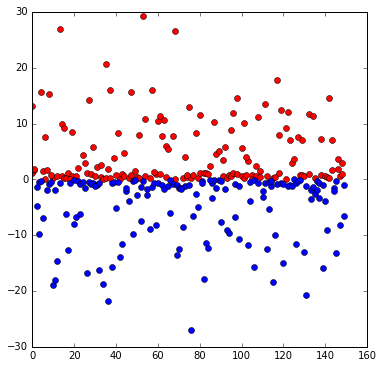

In [867]:
mean   = [0, 0]
cov    = [[1, 0], [0, 100]]
points = np.random.multivariate_normal(mean, cov, 150)
points = np.round(points, decimals = 2)

pos_points = points.copy()
neg_points = points.copy()

pos_points[pos_points <= 0] = np.nan
neg_points[neg_points >  0] = np.nan

plt.plot(pos_points, 'ro', color = 'r')
plt.plot(neg_points, 'ro', color = 'b',)

----
<p>Having visually generated the concept, I will now provide labels for all of the training points.</p>
<p>This means that everything above 0.5 wil have the label <code>0</code> and everything equal to or below 0.5, the label <code>1</code>.</p>
<p>I will create a dataframe which has three columns. Column one and two will be the (x,y) coordinates, and the third column will be the label.</p>

----

In [868]:
pointsDF = pd.DataFrame(points)

scaled = MinMaxScaler(feature_range=(0,1))
pointsDF = scaled.fit_transform(pointsDF)

pointsDF = pd.DataFrame(pointsDF)

In [869]:
pointsDF['label'] = np.where((pointsDF[1] <= 0.5), 2, 1)

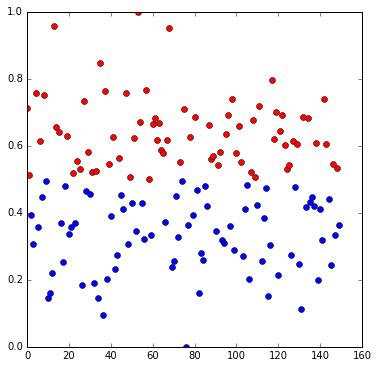

In [870]:
zeros = pointsDF[(pointsDF.label==1)]
ones  = pointsDF[(pointsDF.label==2)]


plt.plot(zeros[1], 'ro', color='r' )
plt.plot(ones[1],  'ro', color='b' )

----

<h3>I have simplified the problem.</h3>
<p>Now there is just one variable, apart from the <code>index</code> and the <code>label</code>. So for instance <code>point 120</code> or <code>point 3</code> or <code>point 43</code> and its correponding value, which takes on a number between <code>0</code> and <code>1</code>. If it is below <code>0.5</code> it takes on the <code>label 1</code> and if it is above <code>0.5</code> it takes on the <code>value 0</code>.</p>

----


<h3>Split into train and test sets, with seperate refs for each column</h3>

In [871]:
trainX = pointsDF.iloc[0:100,1]
#testX  = pointsDF.iloc[101:, 1]

trainY = pointsDF.iloc[0:100,2]
#testY  = pointsDF.iloc[101:, 2]

print(len(trainX), len(trainY))

100 100


In [888]:
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)

In [873]:
print(trainX[0:3])

[ 0.71428571  0.51368159  0.39498934]


In [874]:
print(trainY[0:3])

[1 1 2]


In [803]:
#fig = plt.figure()
#ax = fig.gca(projection='3d')
#ax.scatter(pointsDF.iloc[0:100,0], pointsDF.iloc[0:100,1], pointsDF.iloc[0:100,2])


<h3>Time to build the net...</h3>

In [883]:
import math
import tensorflow as tf

----

<h3>Below</h3>

<p>is a simpler implementation of a classification algorithm</p>

----

In [884]:
learning_rate   = 0.001
training_epochs = 20
batch_size      = 100
display_step    = 1

n_hidden_1 = 256
n_hidden_2 = 256
n_input    = 1
n_classes  = 1

X = tf.placeholder("float")
Y = tf.placeholder("float")

#trainX = tf.convert_to_tensor(trainX)
#trainY = tf.convert_to_tensor(trainY)


In [885]:
def multilayer_perceptron(X, weights, biases):
    layer_1 = tf.add(tf.matmul( X, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b1'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    
    return out_layer

In [886]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred      = multilayer_perceptron(X, weights, biases)
cost      = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init      = tf.initialize_all_variables()

In [ ]:
with tf.Session() as sess:
    
    sess.run(init)
        
    for epoch in range(training_epochs):
        #avg_cost = 0.
        
        for (xs, ys) in zip(trainX, trainY):
            sess.run(optimizer, feed_dict={X:xs, Y:ys})
         
        #sess.run(optimizer, feed_dict = {X: trainX, Y: trainY})    
            
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={xs: trainX, ys: trainY})
    
    print("op finished")
    training_cost = sess.run(cost, feed_dict={x:trainX, y:trainY})
    print(training_cost)

----

<h3>Building a graph function</h3>

<p>It will color each point depending on whether the preceeding point is higher or lower than the given point.</p>

----

<h4>Here is our data</h4>

In [147]:
datapoints = np.linspace(0,30, num=30, endpoint=False)
noisy_datapoints = np.random.randint(4, size=30) + datapoints

30


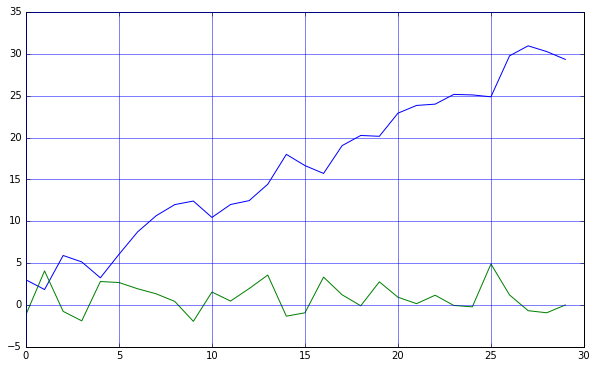

In [148]:
sinCurve       = np.sin(datapoints) + noisy_datapoints
sinCurve_grad  = np.gradient(sinCurve, 1)
# finding the second order derivative is unnecessary: sinCurve_twograd = np.gradient(sinCurve_grad)
#instead of using the gradient, I plan to use the difference between each consecutive point. Is it neg or pos?

sinCurve_diff  = np.diff(sinCurve)

sinCurve_diff = np.insert(sinCurve_diff, 29, 0)
print(len(sinCurve_diff))

sinCurve_diff = pd.Series(sinCurve_diff)

sinCurve_pn = np.where((sinCurve_diff < 0), 'r', 'b')

fig = plt.figure()
ax = fig.gca()
#ax.set_xticks(numpy.arange(0,1,0.1))
#ax.set_yticks(numpy.arange(0,1.,0.1))
    
plt.plot(sinCurve)
plt.plot(sinCurve_diff)

grid(b=True, which='major', color='b', linestyle='-')
grid(b=True, which='minor', color='r', linestyle='--')

<h4>And now for the colouring function in pseudocode:</h4>
<p><code>for eachPoint <i>between</i> Point_2 <i>and<i> Point_n:</code></p>
<p><code>    if [eachPoint - 1] > eachPoint:</code></p>
<p><code>        turn eachPoint red</code></p>
<p><code>    elif [eachPoint - 1] < eachPoint:</code></p>
<p><code>        turn eachPoint blue</code></p>
<p><code>    else:</code></p>
<p><code>        turn eachPoint grey</code></p>

In [149]:
sinCurveDF = pd.DataFrame({'sinCurve': sinCurve, 'diff':sinCurve_diff, 'pn':sinCurve_pn})

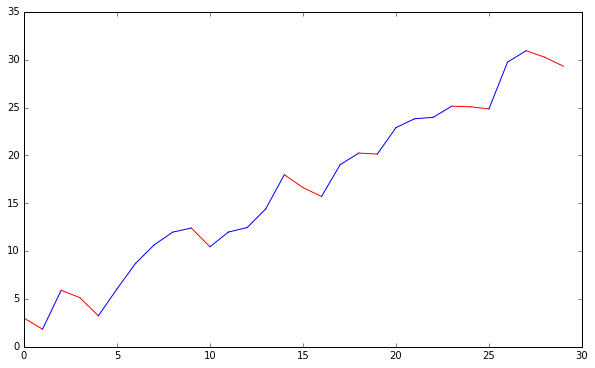

In [150]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
for s in range(0, len(sinCurveDF.sinCurve) - 1):
    x=(sinCurveDF.index[s], sinCurveDF.index[s + 1])
    y=(sinCurveDF.sinCurve[s], sinCurveDF.sinCurve[s + 1])
    ax.plot(x, y, c=sinCurveDF.pn[s])
plt.show()